*Import dependencies*

In [3]:
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

*Read data (the first women data)*

In [4]:
path_01 = r'C:\Users\M.Rodriguez\OneDrive\Desktop\ECG Analysis\ecgDataset\r01.edf'

In [5]:
signals_01, signal_headers_01, header_01 = highlevel.read_edf(path_01)

*Extract annotations from header dictionary*

In [6]:
annotations_full = []
for label in header_01['annotations']:
    annotations_full.append(label[0])

annotations_full = np.array(annotations_full)

In [7]:
annotations_full

array([1.83000e-01, 6.51000e-01, 1.11800e+00, 1.58300e+00, 2.04900e+00,
       2.51400e+00, 2.98200e+00, 3.45100e+00, 3.92000e+00, 4.38900e+00,
       4.85700e+00, 5.32700e+00, 5.79600e+00, 6.26300e+00, 6.73200e+00,
       7.20000e+00, 7.66700e+00, 8.13700e+00, 8.60300e+00, 9.06800e+00,
       9.53300e+00, 9.99900e+00, 1.04620e+01, 1.09260e+01, 1.13890e+01,
       1.18480e+01, 1.23090e+01, 1.27670e+01, 1.32240e+01, 1.36800e+01,
       1.41370e+01, 1.45940e+01, 1.50470e+01, 1.55020e+01, 1.59540e+01,
       1.64100e+01, 1.68630e+01, 1.73170e+01, 1.77730e+01, 1.82310e+01,
       1.86880e+01, 1.91430e+01, 1.96000e+01, 2.00580e+01, 2.05170e+01,
       2.09750e+01, 2.14370e+01, 2.19030e+01, 2.23720e+01, 2.28400e+01,
       2.33080e+01, 2.37750e+01, 2.42440e+01, 2.47110e+01, 2.51730e+01,
       2.56350e+01, 2.60960e+01, 2.65580e+01, 2.70210e+01, 2.74860e+01,
       2.79550e+01, 2.84250e+01, 2.88960e+01, 2.93650e+01, 2.98350e+01,
       3.03060e+01, 3.07750e+01, 3.12430e+01, 3.17090e+01, 3.217

*Define **ecg_FeatureExtraction()** function*

```
- Input(s): signal
- Target: find RS peaks of input signal - calculate Dx and Dy for each RS pair
- Return: Dx_pair, Dy_pair, location of R peaks

```

In [89]:
def ecg_FeatureExtraction(input_signal):

    # calculate local maximums and local minimums
    x = input_signal
    x_reversed = -x
    local_max_0, _ = find_peaks(x, distance = 1)
    local_min_0, _ = find_peaks(x_reversed, distance = 1)


    # calculate max min pairs
    pair_storage = []
    for i in local_max_0:
        for j in local_min_0:
            if j > i:
                pair_storage.append((i, j))
                break

    # feature extraction - Dx and Dy
    Dx_pair = []
    Dy_pair = []
    for pair in pair_storage:
        dx = pair[1] - pair[0]
        dy = np.round(x[pair[1]] - x[pair[0]], 2)
        Dx_pair.append(dx)
        Dy_pair.append(dy)

    # convert Dx_array and Dy_array to numpy array an reshape
    Dx_pair = np.array(Dx_pair)
    Dx_pair = Dx_pair.reshape(Dx_pair.shape[0], 1)

    Dy_pair = np.array(Dy_pair)
    Dy_pair = Dy_pair.reshape(Dy_pair.shape[0], 1)

    return Dx_pair, Dy_pair, local_max_0


*Define **ecg_clustering()** function*

```
- Input(s): input_feature, R_peaks_locations, starting sample and ending sample of input signal, extracted annotations
- Target: create KMeans model, fit the model on the input feature, determine fetal and maternal cluster
- Return: maternal_cluster, fetal_cluster, related annotations

```

In [185]:
def ecg_clustering(input_feature, maximum_pairs, start_sample, end_sample, labels):

    from sklearn.cluster import KMeans

    # Apply kmeans on Dy feature
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(input_feature)

    first_cluster_ind = np.where(kmeans.labels_ == 0)
    second_cluster_ind = np.where(kmeans.labels_ == 1)
    third_cluster_ind = np.where(kmeans.labels_ == 2)

    first_cluster = maximum_pairs[first_cluster_ind[0]] + start_sample
    second_cluster = maximum_pairs[second_cluster_ind[0]] + start_sample
    third_cluster = maximum_pairs[third_cluster_ind[0]] + start_sample

    cluster_list = [first_cluster, second_cluster, third_cluster]
    cluster_len_list = np.array([len(first_cluster), len(second_cluster), len(third_cluster)])

    condition = (labels > start_sample / 1000) & (labels < end_sample / 1000)
    annotations = labels[np.where(condition)]

    difference = np.abs(cluster_len_list - len(annotations))
    difference_sorted = np.sort(difference)
    fetal_cluster = cluster_list[np.where(difference == difference_sorted[0])[0][0]]
    maternal_cluster = cluster_list[np.where(difference == difference_sorted[1])[0][0]]
    
    return maternal_cluster, fetal_cluster, annotations
        

*Define **visualize_results()** function*

```
- Input(s): input_signal, R_peaks_locations, starting sample and ending sample of input signal, location of maternal and fetal cluster R peaks
- Target: create subplots - plot three signal, the first is fetal ECG, the second is Abdominal ECG and the third is AECG with detected R peaks
- Return: no return - just visualization

```

In [91]:
def visualize_results(input_signal, start_sample, end_sample, maternal_cluster, fetal_cluster):

    _, ax = plt.subplots(3, 1, figsize = (10, 12))

    ax[0].plot(signals_01[0, start_sample:end_sample])
    ax[0].set_title('Fetal ECG')

    ax[1].plot(signals_01[1, start_sample:end_sample])
    ax[1].set_title('Abdominal Maternal ECG')

    ax[2].plot(input_signal)
    ax[2].plot(maternal_cluster - start_sample, input_signal[maternal_cluster - start_sample], ".", color = 'red')
    ax[2].plot(fetal_cluster - start_sample, input_signal[fetal_cluster - start_sample], ".", color = 'green')
    ax[2].legend(['AECG', 'Maternal QRS', 'Fetal QRS'])

    plt.show()
    

*Define **calc_score()** function*

```
- Input(s): fetal cluster as target cluster, annotations to compare the output of the KMeans model with real labels (R peak locations of fetal)
- Target: calculate false_negative, false_possitive, true_possitive, precision, recall and F1 score of the model
- Additional notes: FN occurs when FQRS overlap with MQRS, FP occurs when we have noise with same amplitude of FQRS
- Return: a dictionary that contains FN, FP, TP, precision, recall and F1 score

```

In [92]:
def calc_score(target_cluster, annotations):

    output_seconds = target_cluster / 1000

    # go for calculating FP, FN, TP, Precision, Recall and F1-Score
    FP = 0
    FN = 0
    TP = 0

    for label in annotations:
        counter = 0
        for output in output_seconds: 
            if abs(label - output) < 0.01:
                counter += 1
                TP += 1

        if counter == 0:
            FN += 1
        
    for output in output_seconds:
        counter = 0
        for label in annotations:
            if abs(label - output) < 0.01:
                counter += 1
        if counter == 0:
            FP += 1


    # calculate precision and recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    # print('precision: ', precision)
    # print('recall', recall)

    # calculate F1-Score
    F1 = 2 / (1 / precision + 1 / recall)
    # print('f1', F1)

    storage_dict = {
        'FN' : FN,
        'FP' : FP,
        'TP' : TP,
        'precision' : precision,
        'recall' : recall,
        'F1-score' : F1
    }

    return storage_dict

## *Input Feature : Dy (y-axis direction distance between RS peaks)*

*Applying clustering on the main signal - duration of 0 to 150 seconds*

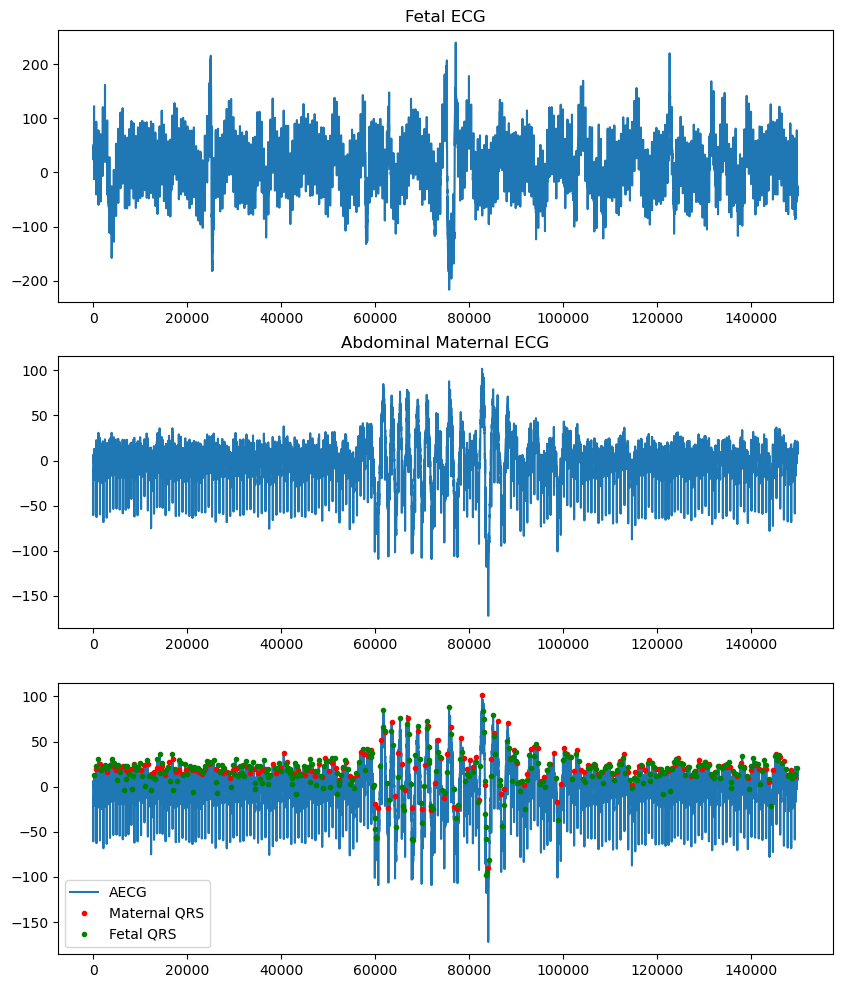

{'FN': 23, 'FP': 62, 'TP': 297, 'precision': 0.8272980501392758, 'recall': 0.928125, 'F1-score': 0.8748159057437408}


In [171]:
start_sample = 0
end_sample = 150000
x = signals_01[1, start_sample:end_sample]
Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(x)
maternal_cluster, fetal_cluster, annotations = ecg_clustering(Dy_pair, local_max_0, start_sample, end_sample, annotations_full)
visualize_results(x, start_sample, end_sample, maternal_cluster, fetal_cluster)
results = calc_score(fetal_cluster, annotations)
print(results)

### *Work with Frequency Domain (Filtering)*

*Calculating DFT of main signal and the frequency interval*

In [102]:
dft = np.fft.fft(signals_01[1])
frequency = np.linspace(0, 1000, len(dft))

*Plot the magnitude of DFT in the interval of [0, 200] Hz*

Text(0.5, 1.0, 'Magnitude of DFT')

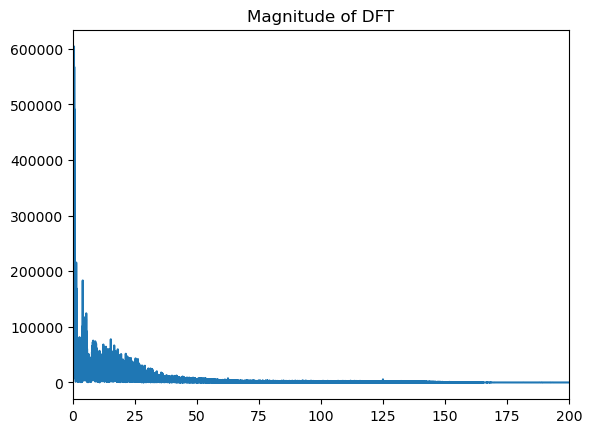

In [103]:
plt.plot(frequency, np.abs(dft))
plt.xlim([0, 200])
plt.title('Magnitude of DFT')

*Define **lowPassFiltering()** function*

```
- Input(s): input_signal which we want to apply filtering on, sampling frequency (1000 in our case), cutoff frequency based on the graph above
- Target: calculate low pass filter and apply on the input_signal
- Return: filtered signal

```

In [104]:
def lowPassFiltering(input_signal, sampling_freq, cutoff_freq):

    dft = np.fft.fft(input_signal)
    frequency = np.linspace(0, sampling_freq, len(dft))

    lpf_condition = (frequency > cutoff_freq) & (frequency < sampling_freq - cutoff_freq)
    dft_filtered_low = np.where(lpf_condition, 0, dft)
    filtered_signal = np.real(np.fft.ifft(dft_filtered_low))

    return  filtered_signal

*Define **highPassFiltering()** function*

```
- Input(s): input_signal which we want to apply filtering on, sampling frequency (1000 in our case), cutoff frequency (user defined)
- Target: calculate high pass filter and apply on the input_signal
- Return: filtered signal

```

In [186]:
def highPassFiltering(input_signal, sampling_freq, cutoff_freq):

    dft = np.fft.fft(input_signal)
    frequency = np.linspace(0, sampling_freq, len(dft))

    lpf_condition = (frequency > cutoff_freq) & (frequency < sampling_freq - cutoff_freq)
    dft_filtered_low = np.where(lpf_condition, dft, 0)
    filtered_signal = np.real(np.fft.ifft(dft_filtered_low))

    return  filtered_signal

*Apply low pass filter with cutoff frequency of 200 on the main signal*

In [177]:
signal_filtered_low = lowPassFiltering(signals_01[1], sampling_freq = 1000, cutoff_freq = 200)

*Plot the main signal anf filtered signal*

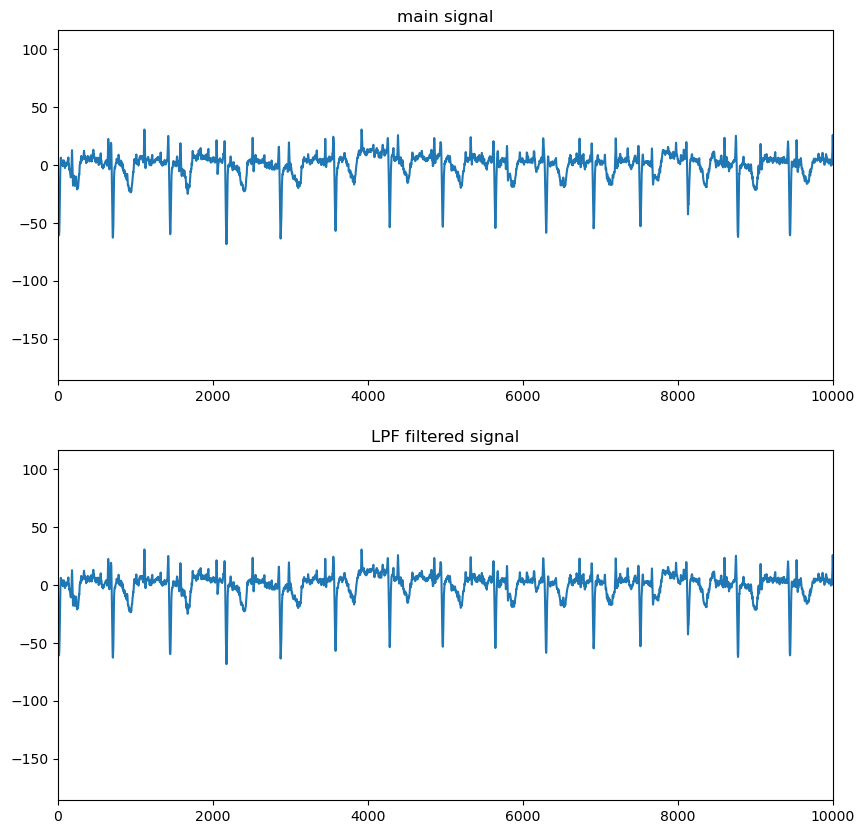

In [178]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

ax[0].plot(signals_01[1])
ax[0].set_xlim([0, 10000])
ax[0].set_title('main signal')

ax[1].plot(signal_filtered_low)
ax[1].set_xlim([0, 10000])
ax[1].set_title('LPF filtered signal')
plt.show()

*Applying clustering on the low pass filtered signal - duration of 0 to 150 seconds*

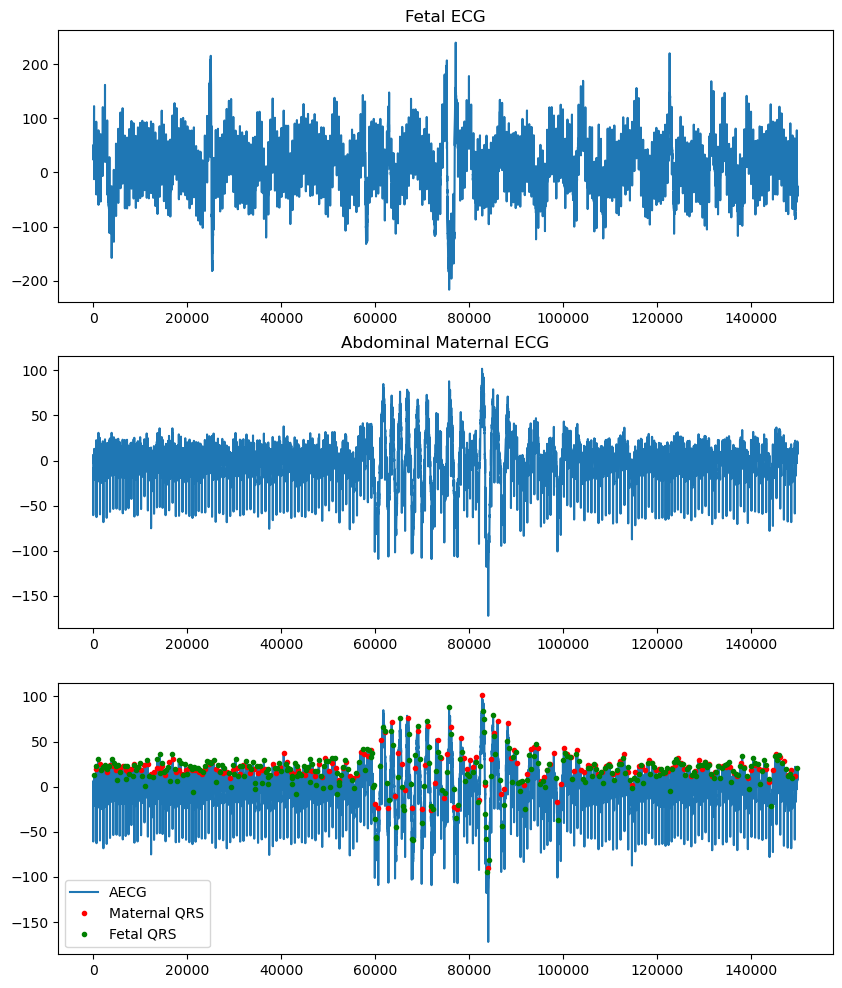

{'FN': 26, 'FP': 38, 'TP': 294, 'precision': 0.8855421686746988, 'recall': 0.91875, 'F1-score': 0.9018404907975459}


In [179]:
x = signal_filtered_low[start_sample:end_sample]
Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(x)
second_cluster, third_cluster, annotations = ecg_clustering(Dy_pair, local_max_0, start_sample, end_sample, annotations_full)
visualize_results(x, start_sample, end_sample, second_cluster, third_cluster)
results = calc_score(third_cluster, annotations)
print(results)

*Apply high pass filter with cutoff frequency of 1 on the main signal*

In [181]:
signal_filtered_high = highPassFiltering(signals_01[1], sampling_freq = 1000, cutoff_freq = 1)

*Plot the main signal anf filtered signal*

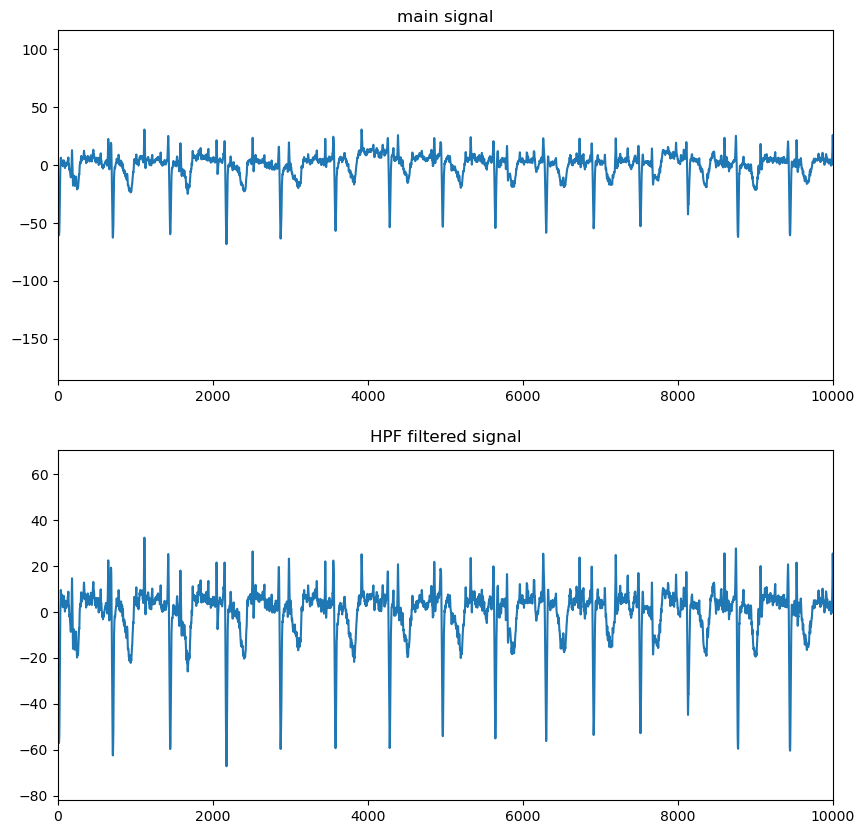

In [119]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

ax[0].plot(signals_01[1])
ax[0].set_xlim([0, 10000])
ax[0].set_title('main signal')

ax[1].plot(signal_filtered_high)
ax[1].set_xlim([0, 10000])
ax[1].set_title('HPF filtered signal')
plt.show()

*Applying clustering on the high pass filtered signal - duration of 0 to 150 seconds*

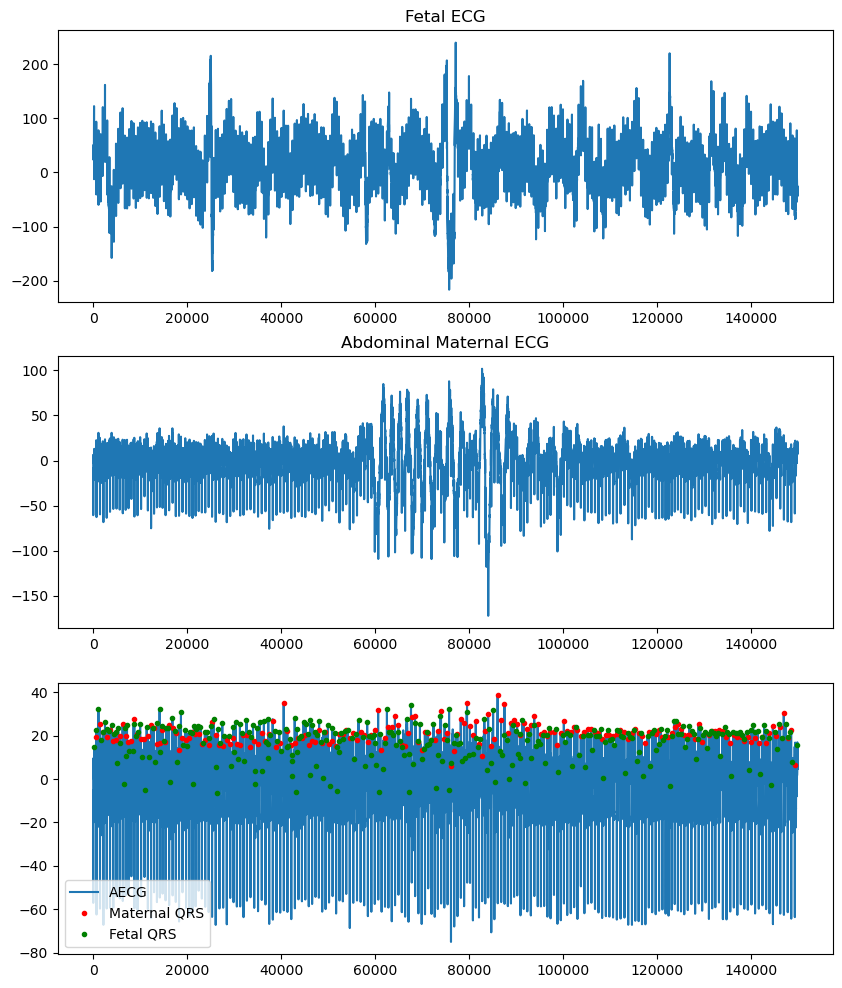

{'FN': 24, 'FP': 31, 'TP': 296, 'precision': 0.9051987767584098, 'recall': 0.925, 'F1-score': 0.9149922720247297}


In [182]:
x = signal_filtered_high[start_sample:end_sample]
Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(x)
second_cluster, third_cluster, annotations = ecg_clustering(Dy_pair, local_max_0, start_sample, end_sample, annotations_full)
visualize_results(x, start_sample, end_sample, second_cluster, third_cluster)
results = calc_score(third_cluster, annotations)
print(results)

*Apply high pass filter with cutoff frequency of 1 on the low pass filtered signal*

In [183]:
signal_filtered_high_02 = highPassFiltering(signal_filtered_low, sampling_freq = 1000, cutoff_freq = 1) 

*Applying clustering on the high pass filtered signal - duration of 0 to 150 seconds*

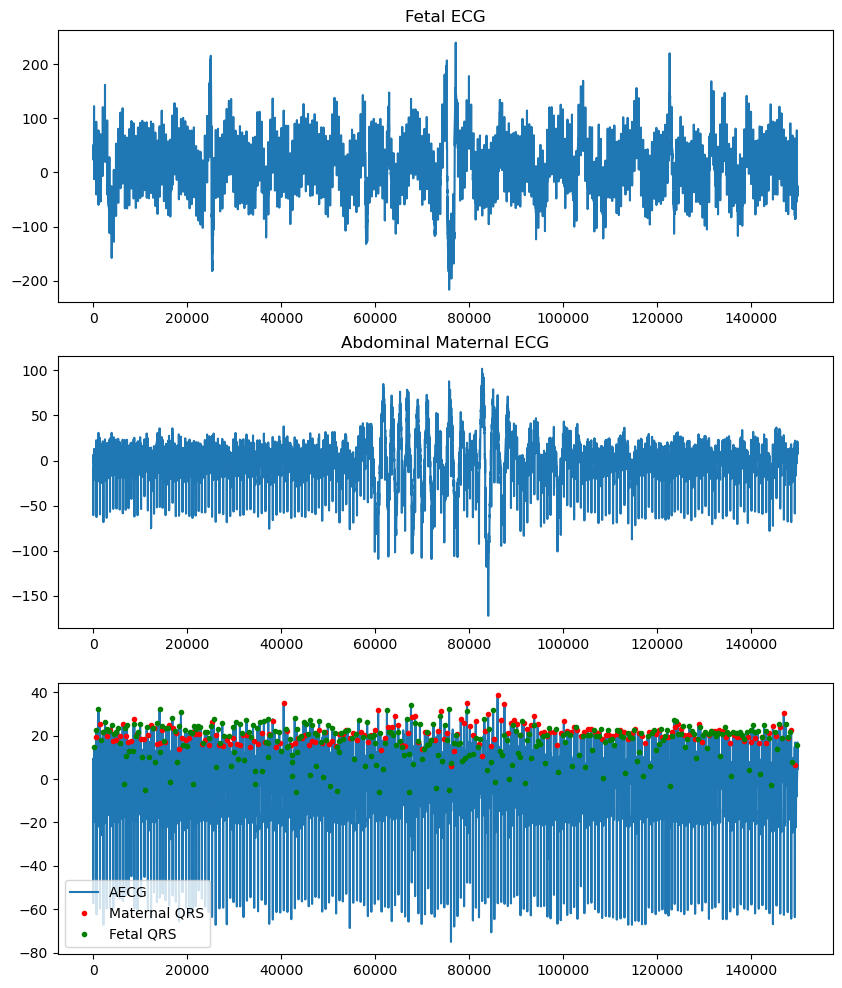

{'FN': 24, 'FP': 29, 'TP': 296, 'precision': 0.9107692307692308, 'recall': 0.925, 'F1-score': 0.9178294573643412}


In [184]:
x = signal_filtered_high_02[start_sample:end_sample]
Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(x)
second_cluster, third_cluster, annotations = ecg_clustering(Dy_pair, local_max_0, start_sample, end_sample, annotations_full)
visualize_results(x, start_sample, end_sample, second_cluster, third_cluster)
results = calc_score(third_cluster, annotations)
print(results)

> ##### *As we can see, the best results is for the filtered signal, applying a lowpass filter with cutoff frequency of 200 Hz and a high pass filter with cutoff frequency of 1 Hz*

------------------

### *WindowSize Tunning*

*Define **tunning_windowSize()** function*

```
- Input(s): input_signal which we want to apply tunning on, an array that contains different window_size to test
- Target: separate the input_signal to the sub_signals with the size of each window_size, applying clustering on each sub_signal, calculate total FN, FP, TP and final precision, recall and F1 score, store the results of each window size in two separate array
- Return: two arrays - the first is all the F1 scores of different window_sizes which mentioned in windows_array, the second is an array contains all dictionaries that store results of each window_size

```

In [162]:
def tunning_windowSize(input_signal, windows_array : list):

    scores_storge = [] # store the F1 score of each training in this list
    results_storage = [] # store the result dict of each training in this list

    for window_size in windows_array:

        signal_batch = len(input_signal) // (window_size * 1000)
        signal_storage = np.split(input_signal, signal_batch)
        FN, FP, TP = 0, 0, 0
        for i in range(len(signal_storage)):
            
            signal = signal_storage[i]
            start_sample = i * window_size * 1000
            end_sample = (i + 1) * window_size * 1000
            
            Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(signal)
            maternal_cluster, fetal_cluster, annotations = ecg_clustering(Dy_pair, local_max_0, start_sample, end_sample, annotations_full)
            
            results = calc_score(fetal_cluster, annotations)

            FN += results['FN']
            FP += results['FP']
            TP += results['TP']

        # calculate precision and recall
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)

        # calculate F1-Score
        F1 = 2 / (1 / precision + 1 / recall)
        
        storage_dict = {
        'window_size' : window_size,
        'FN' : FN,
        'FP' : FP,
        'TP' : TP,
        'precision' : precision,
        'recall' : recall,
        'F1-score' : F1
        }

        results_storage.append(storage_dict)
        scores_storge.append(F1)

    return scores_storge, results_storage


*WindowSize tunning on the main signal*

In [128]:
windows = [10, 20, 30, 50, 60, 100, 150]
score_storage, results_storage = tunning_windowSize(signals_01[1], windows)

In [129]:
score_storage

[0.862179487179487,
 0.8361581920903954,
 0.8587479935794543,
 0.8087520259319286,
 0.9100691775557264,
 0.907563025210084,
 0.9068702290076336]

> ##### *as we can see in the list above, the best window size based on main signal is 60 seconds with the score of 91%*

*WindowSize tunning on the filtered signal*

In [130]:
score_storage, results_storage = tunning_windowSize(signal_filtered_high_02, windows)

In [131]:
score_storage

[0.9092356687898091,
 0.9307086614173229,
 0.9344909234411997,
 0.9323899371069182,
 0.9352290679304897,
 0.9323899371069182,
 0.9323899371069182]

> ##### *as we can see in the list above, the best window size based on filtered signal is 60 seconds with the score of 93.5%*

## *Input Feature : Dx * Dy*

*Applying clustering on the main signal - duration of 0 to 150 seconds*

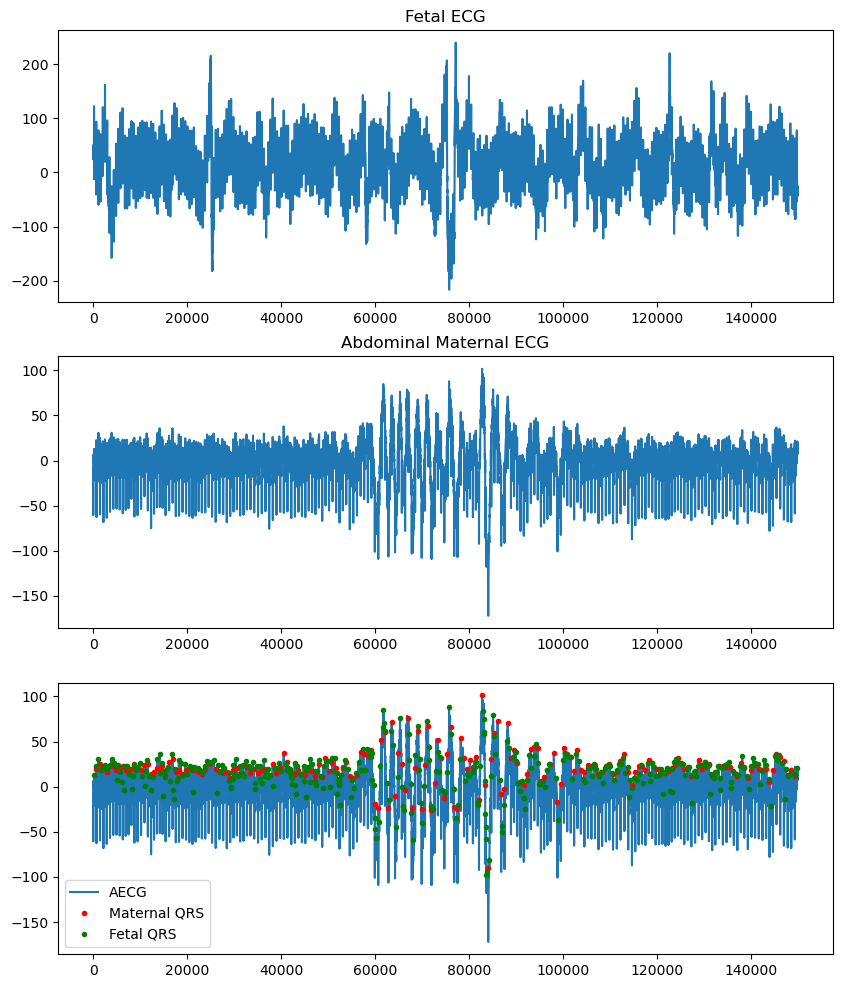

{'FN': 29, 'FP': 88, 'TP': 291, 'precision': 0.7678100263852242, 'recall': 0.909375, 'F1-score': 0.832618025751073}


In [172]:
x = signals_01[1, start_sample:end_sample]
Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(x)
DxDy = Dx_pair * Dy_pair
second_cluster, third_cluster, annotations = ecg_clustering(DxDy, local_max_0, start_sample, end_sample, annotations_full)
visualize_results(x, start_sample, end_sample, second_cluster, third_cluster)
results = calc_score(third_cluster, annotations)
print(results)

*Applying clustering on the high pass filtered signal - duration of 0 to 150 seconds*

In [173]:
signal_low = lowPassFiltering(x, sampling_freq = 1000, cutoff_freq = 200)
signal_high = highPassFiltering(signal_low, sampling_freq = 1000, cutoff_freq = 1)

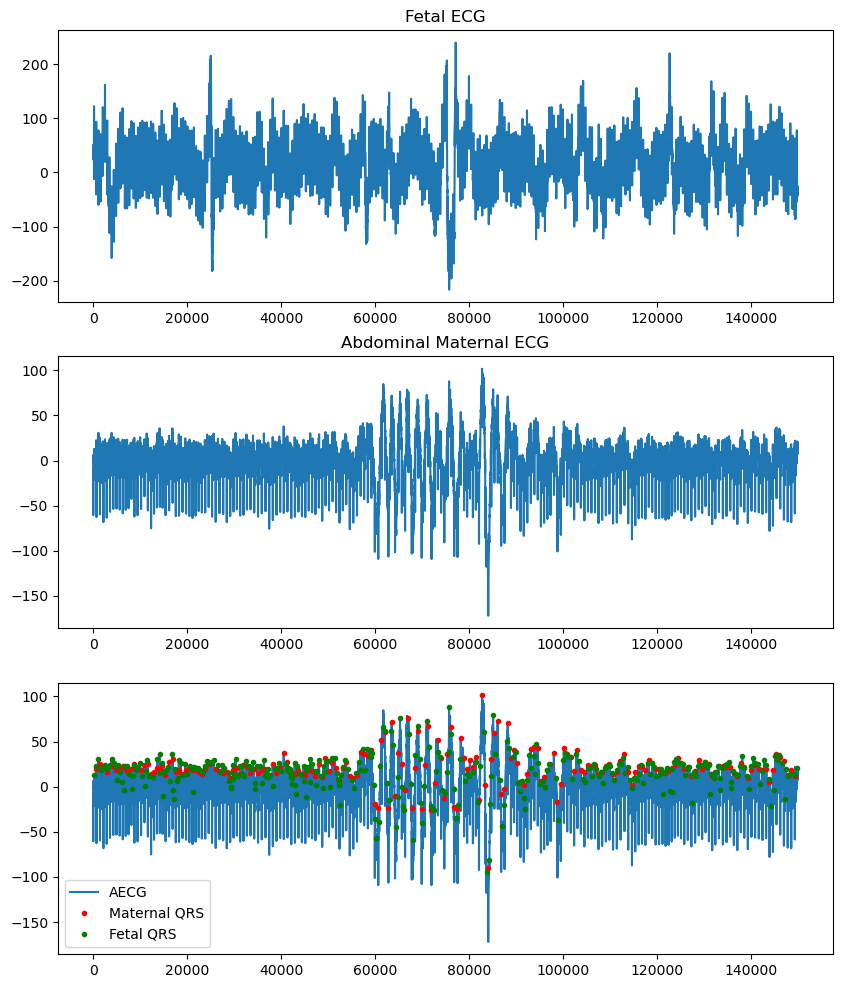

{'FN': 29, 'FP': 62, 'TP': 291, 'precision': 0.8243626062322946, 'recall': 0.909375, 'F1-score': 0.8647845468053492}


In [174]:
Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(signal_high)
DxDy = Dx_pair * Dy_pair
second_cluster, third_cluster, annotations = ecg_clustering(DxDy, local_max_0, start_sample, end_sample, annotations_full)
visualize_results(x, start_sample, end_sample, second_cluster, third_cluster)
results = calc_score(third_cluster, annotations)
print(results)

> ##### *As we can see in the results with the input feature of Dx * Dy, **the performace of Dy feature is better than Dx * Dy***